In [32]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime
from matplotlib.figure import Figure

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from datetime import datetime
%load_ext google.cloud.bigquery
from google.cloud import bigquery

from datetime import datetime
from collections import namedtuple

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [10]:
data = pd.read_excel('Porvoo_August14_new production and tank transfers.xlsx',  index_col=None)
data.to_csv('Porvoo_August14_tank.csv',  index=False)


In [100]:
df = pd.read_csv('Porvoo_August14_tank.csv',skiprows = 1)

In [101]:
df = df.rename(index=str, columns={"Tilauksen nro/siirron nro":"order_no",
                                   "Lähde":"source",
                                   'Linjat':'lines',
                                   'Määränpää':'destination',
                                   'Kategoria':'category',
                                   
                                   'Siirrettävää':'to_move',
                                   'Siirretty' : 'moved', 
                                   'Diff src/dst' :'diff_source_dest', 
                                   'Via delta' : 'via_delta',
      
                                   'Yksikkö' : 'unit',
                                   'Tuote' : 'product',
                                   'Asiakas-spekki' : 'customer_spec', 
                                    'Aloitusaika' :'start_time',
                                   'Finish time' :'finish_time',
                                  'Source delta' : 'source_delta',
       'Destination delta': 'destination_delta'
                                })

In [102]:
df = df[['order_no', 'lines', 'destination', 'category', 'to_move',
       'moved', 'diff_source_dest', 'via_delta', 'unit', 'product',
      'source_delta', 'start_time', 'finish_time']]

In [103]:
df['destination'] = df['destination'].astype(str)
df['destination'] = df['destination'].replace(' ', np.nan)
df.dropna(subset=['destination'],inplace = True)
df = df.reset_index(drop = True)

In [104]:
df['start_time'] =  pd.to_datetime(df['start_time'], errors='coerce')
df['finish_time'] =  pd.to_datetime(df['finish_time'], errors='coerce')
df['op_time'] =(df['finish_time'] - df['start_time']).astype('timedelta64[m]') 
df['op_time'] = df['op_time'].apply(lambda x :round(x/60,2))

In [105]:
df['moved'] = df['moved'].astype(float)
df['to_move'] = df['to_move'].astype(float)
df['speed'] = round(df['moved'] / df['op_time'],2)
df['product'] = df['product'].apply(lambda x: str(x)[:7])
df['destination'] = df['destination'].apply(lambda x: str(x)[:10])

In [106]:
# drop where tomove or moved == 0

In [107]:
df = df[ (df['moved'] > 0) & (df['to_move'] > 0)]

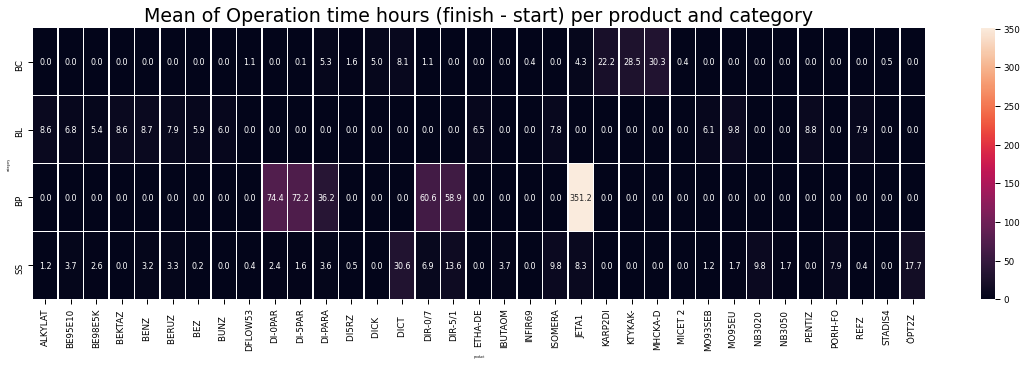

In [108]:
plt.figure(figsize=(20,5))
dff = df[df.groupby('product')['product'].transform('count').ge(9)].reset_index(drop = True)
dff = dff[dff.groupby('category')['category'].transform('count').ge(1)].reset_index(drop = True)
df_opera = dff.pivot_table(
                        index='category', 
                        columns='product', 
                        values='op_time', 
                        aggfunc=np.mean).fillna(0).applymap(float)
sns.heatmap(df_opera, annot=True, fmt=".1f", linewidths=.5).set_title('Mean of Operation time hours (finish - start) per product and category');

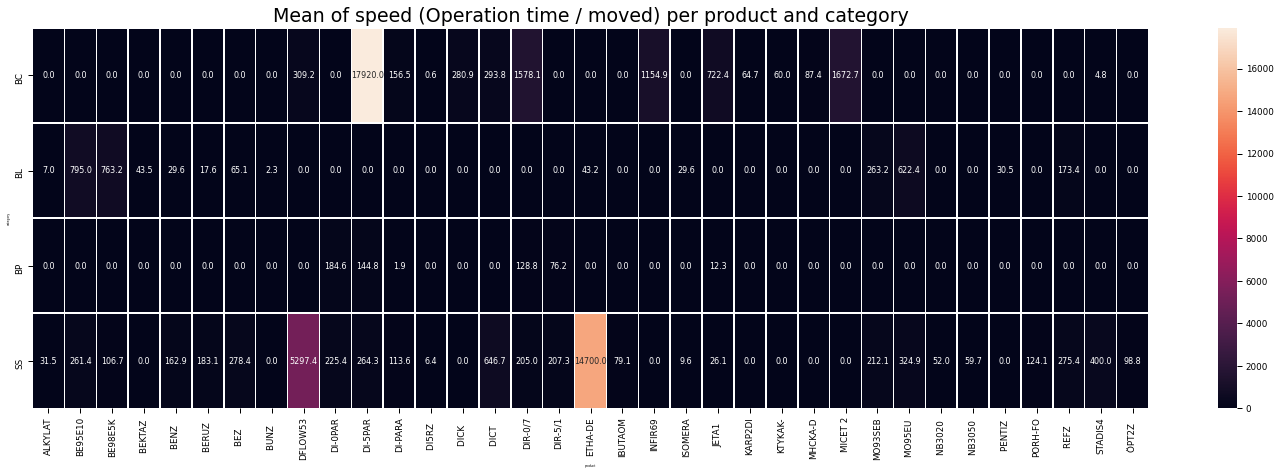

In [110]:
plt.figure(figsize=(25,7))
df1 = dff[dff['speed'] > 300]
df_opera = dff.pivot_table(
                        index='category', 
                        columns='product', 
                        values='speed', 
                        aggfunc=np.min).fillna(0).applymap(float)
sns.heatmap(df_opera, annot=True, fmt=".1f", linewidths=.5).set_title('Mean of speed (Operation time / moved) per product and category');

Text(0.5, 1.0, 'Operation time (hours) per product for BL blending products')

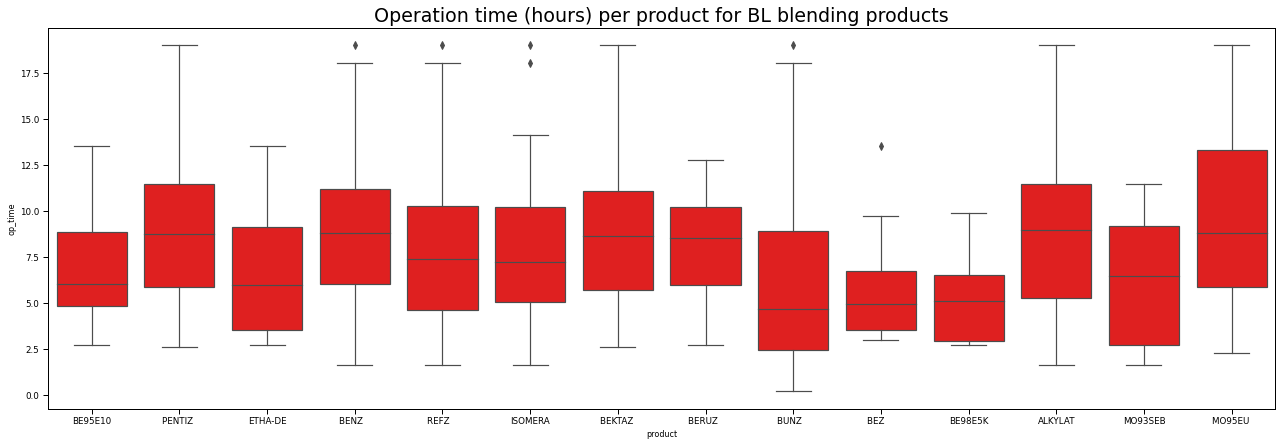

In [127]:
plt.figure(figsize=(22,7))
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":19,"axes.labelsize":8})   

sns.boxplot(
    data=dff[dff['category'] == 'BL'],
    x='product',
    y='op_time',
    color='red').set_title('Operation time (hours) per product for BL blending products')



In [118]:
a=df[df['op_time'] < 150]

Text(0.5, 1.0, 'Operation time (hours)')

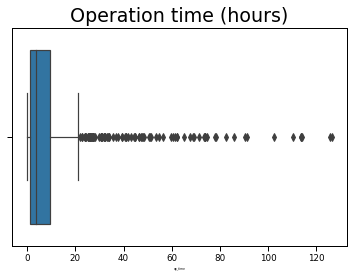

In [120]:
sns.boxplot(a['op_time']).set_title('Operation time (hours)')

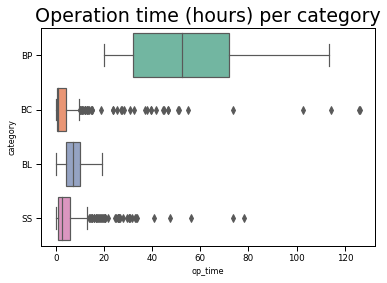

In [130]:

ax = sns.boxplot(x= a['op_time'], y =a["category"], palette="Set2").set_title('Operation time (hours) per category')

In [176]:
c = df[df['speed'] < 1500]

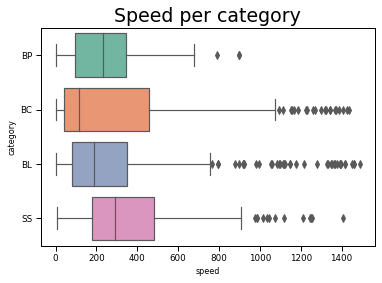

In [177]:

ax = sns.boxplot(x= c['speed'], y = c["category"], palette="Set2").set_title('Speed per category')

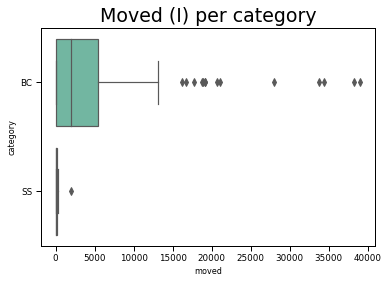

In [157]:
b= df[df['unit'] == 'I']
ax = sns.boxplot(x= b['moved'], y =b["category"], palette="Set2").set_title('Moved (I) per category')

In [152]:
df['unit'].value_counts()

m3       562
m3@15    366
I        152
Name: unit, dtype: int64

Text(0.5, 1.0, 'Operation time (hours) per product for BP blending products')

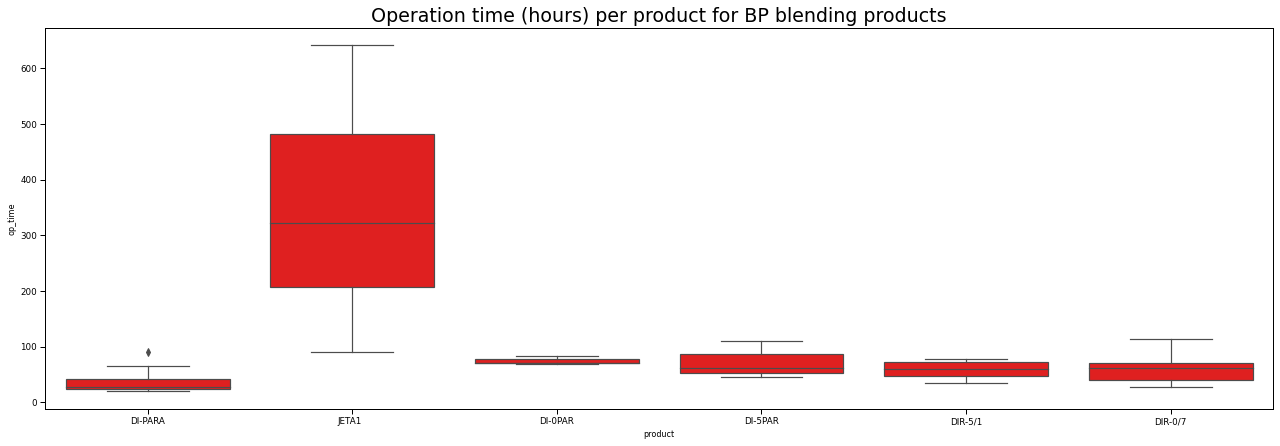

In [131]:
plt.figure(figsize=(22,7))
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":19,"axes.labelsize":8})   

sns.boxplot(
    data=dff[dff['category'] == 'BP'],
    x='product',
    y='op_time',
    color='red').set_title('Operation time (hours) per product for BP blending products')



Text(0.5, 1.0, 'Operation time (hours) per product for BC blending components')

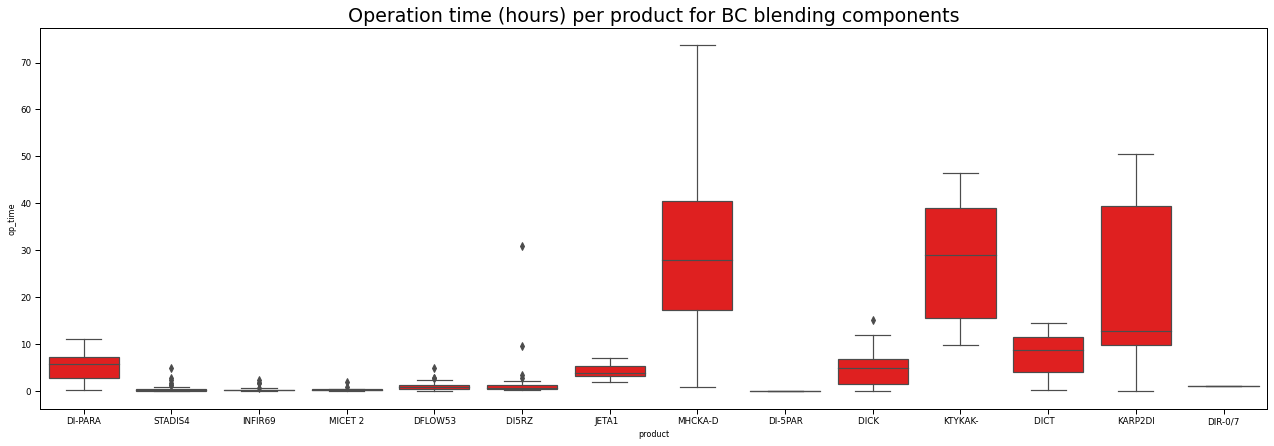

In [132]:
plt.figure(figsize=(22,7))
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":19,"axes.labelsize":8})   

sns.boxplot(
    data=dff[dff['category'] == 'BC'],
    x='product',
    y='op_time',
    color='red').set_title('Operation time (hours) per product for BC blending components')


Text(0.5, 1.0, 'Operation time (hours) per product for BL=gasoline products or components')

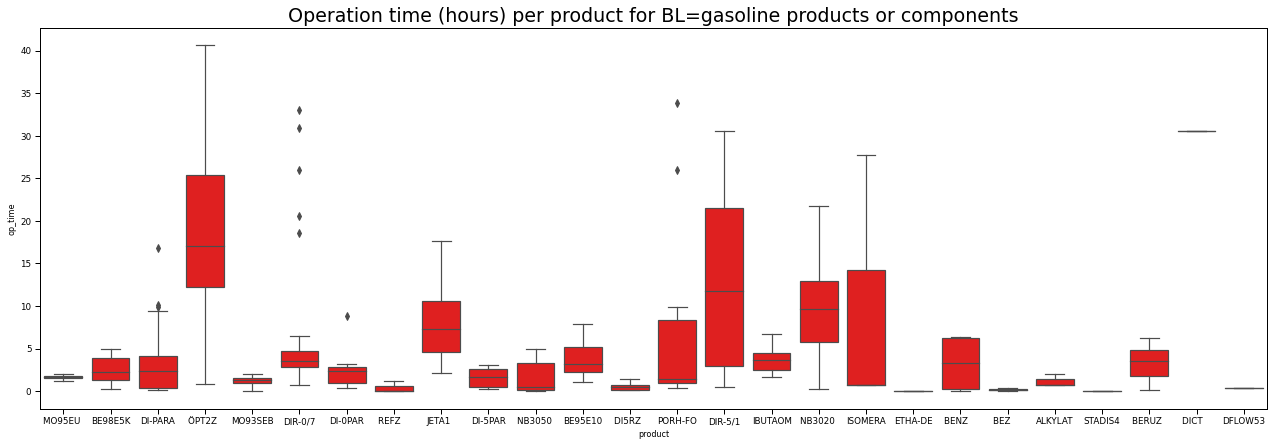

In [141]:
plt.figure(figsize=(22,7))
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":19,"axes.labelsize":8})   

sns.boxplot(
    data=dff[dff['category'] == 'SS'],
    x='product',
    y='op_time',
    color='red').set_title('Operation time (hours) per product for BL=gasoline products or components')


Text(0.5, 1.0, 'Speed distribution per product, category BP')

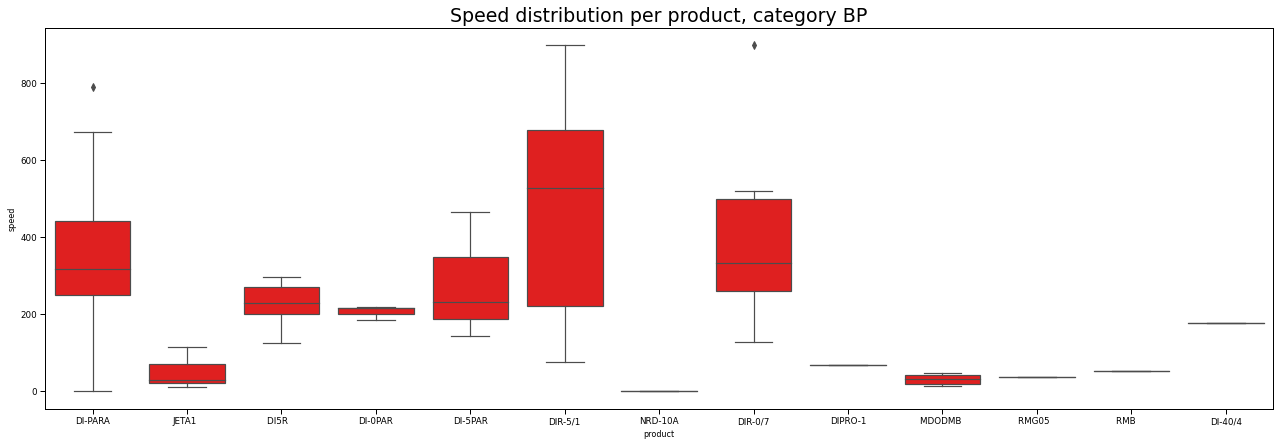

In [180]:
#dff = df[df.groupby('vessel')['vessel'].transform('count').ge(3)].reset_index(drop = True)

plt.figure(figsize=(22,7))
sns.boxplot(
    data=df[df['category'] == 'BP'],
    x='product',
    y='speed',
    color='red').set_title('Speed distribution per product, category BP')